In [1]:
from __future__ import annotations

import re
import os
import glob
from typing import Dict

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.collections import PolyCollection
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import pipeline

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

c:\github\crosswriters\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
meta = pd.read_excel('data/metadata.xlsx')
meta.sample(5)

,File name,Author,Title,Publication date,Series + n°,Editor,Illustrator,Publisher,Place of publication,Intended reader,Source intended reader,Date of debut,Author's birth date,Author's age at time of publication,Author's gender,Country,Comments,English title
598,VANLEEUWEN_kweenie_2003,Joke van Leeuwen,Kweenie,2003,NaN,NaN,Joke van Leeuwen,Querido,Amsterdam,7,NaN,1978,1952,51,F,NL,NaN,NaN
682,WILSON_mysecretdiary_2009,Jacqueline Wilson,My Secret Diary,2009,NaN,NaN,Nick Sharratt,Doubleday,London,12,website author,1969,1945,64,F,UK,NaN,NaN
169,FINE_rakingtheashes_2005,Anne Fine,Raking the Ashes,2005,NaN,NaN,NaN,Bantam Press,London,18,website author,1978,1947,58,F,UK,NaN,NaN
590,VANLEEUWEN_ditboekheetanders_1992,Joke van Leeuwen,Dit boek heet anders,1992,NaN,NaN,Joke van Leeuwen,Querido,Amsterdam,9,NaN,1978,1952,40,F,NL,NaN,NaN
77,BLACKMAN_tellmenolies_1999,Malorie Blackman,Tell Me No Lies,1999,NaN,NaN,NaN,Macmillan,London,9,CBK,1990,1962,37,F,UK,NaN,NaN


In [3]:
meta.shape

(753, 18)

In [4]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   File name                            753 non-null    object
 1   Author                               753 non-null    object
 2   Title                                753 non-null    object
 3   Publication date                     753 non-null    int64 
 4   Series  + n°                         167 non-null    object
 5   Editor                               1 non-null      object
 6   Illustrator                          410 non-null    object
 7   Publisher                            741 non-null    object
 8   Place of publication                 739 non-null    object
 9   Intended reader                      753 non-null    object
 10  Source intended reader               643 non-null    object
 11  Date of debut                        753 non-

In [5]:
memory_before = meta.memory_usage(deep=True).sum() / 1024

## Cleaning up the dataset

(following [Matt Harrison's](https://twitter.com/__mharrison__) 'chaining' approach to Pandas)

In [6]:
meta = (
    meta
    .rename(lambda col: col.replace(' ', '_').lower(), axis=1)
    .rename(columns={'publication_date': 'pub_year', "author's_age_at_time_of_publication": 'author_age_pub', "author's_gender": 'author_gender'})
    .loc[:, ['file_name', 'author', 'title', 'pub_year', 'intended_reader', 'author_age_pub', 'author_gender', 'country']]
    .dropna(axis=0, how='any')
    .query(
        "country == 'UK' & \
        intended_reader != '-' & \
        author.str.contains('/') == False"
    )
    .astype({
        'author': 'category',
        'intended_reader': int,
        'author_gender': 'category'
    })
)

pd.to_datetime(meta['pub_year'], format='%Y')
meta.sample(10)

,file_name,author,title,pub_year,intended_reader,author_age_pub,author_gender,country
34,BLACKMAN_antidote_1996,Malorie Blackman,A.N.T.I.D.O.T.E,1996,9,34,F,UK
102,CHAMBERS_thetollbridge_1992,Aidan Chambers,The Toll Bridge,1992,15,58,M,UK
16,ALMOND_heaveneyes_2000,David Almond,Heaven Eyes,2000,12,49,M,UK
685,WILSON_opalplumstead_2014,Jacqueline Wilson,Opal Plumstead,2014,9,69,F,UK
20,ALMOND_mydadsabirdman_2007,David Almond,My Dad's a Birdman,2007,8,56,M,UK
69,BLACKMAN_perilonplanetpellia_1996,Malorie Blackman,Peril on Planet Pellia,1996,7,34,F,UK
258,GAIMAN_mirrormask_2005,Neil Gaiman,MirrorMask,2005,8,45,M,UK
25,ALMOND_theboywhoswamwithpiranhas_2012,David Almond,The Boy Who Swam With Piranhas,2012,8,61,M,UK
699,WILSON_thecatmummy_2001,Jacqueline Wilson,The Cat Mummy,2001,7,56,F,UK
209,FINE_verydifferent_2001,Anne Fine,Very Different,2001,12,54,F,UK


In [7]:
meta = (meta
    .assign(reader_age_group=np.where(meta['intended_reader'] == 18, 'adult' , 'child'))
    .astype({'reader_age_group': 'category'})
    .drop(['country', 'intended_reader'], axis=1)
)

In [8]:
meta.shape

(327, 7)

In [9]:
memory_after = meta.memory_usage(deep=True).sum() / 1024

In [10]:
# memory difference
print(f"{abs(memory_after - memory_before):.2f} KB")

535.15 KB


In [11]:
meta.to_csv('data/metadata_en_baseline_sample.csv', index=False, encoding='utf-8')

### Remove authors who have published for one age group only

In [12]:
meta.groupby('reader_age_group')['author'].value_counts(sort=False)

reader_age_group                      
adult             Aidan Chambers           0
                  Anne Fine                9
                  David Almond             2
                  Frank Cottrell-Boyce     0
                  J.K. Rowling             6
                  Jacqueline Wilson        0
                  Jamila Gavin             0
                  Jill Murphy              0
                  Malorie Blackman         0
                  Neil Gaiman              6
                  Philip Pullman           3
child             Aidan Chambers          11
                  Anne Fine               74
                  David Almond            22
                  Frank Cottrell-Boyce    13
                  J.K. Rowling             8
                  Jacqueline Wilson       69
                  Jamila Gavin            13
                  Jill Murphy             10
                  Malorie Blackman        50
                  Neil Gaiman              8
                

In the output above, we see that all authors have published books for children. We therefore need to filter out those who haven't published for adults.

In [13]:
df = (meta
    .groupby('author')
    .filter(lambda _df: _df['reader_age_group'].nunique() == 2)
)

print("Before:", meta['reader_age_group'].value_counts(sort=False), sep='\n', end='\n\n')
print("After: ", df['reader_age_group'].value_counts(sort=False), sep='\n')

Before:
adult     26
child    301
Name: reader_age_group, dtype: int64

After: 
adult     26
child    135
Name: reader_age_group, dtype: int64


In [14]:
(df
    .groupby('author', observed=True)['reader_age_group']  # `observed=True`: Hide authors with 0 observations
    .value_counts(dropna=True)
)

author               
David Almond    child    22
                adult     2
Anne Fine       child    74
                adult     9
Neil Gaiman     child     8
                adult     6
Philip Pullman  child    23
                adult     3
J.K. Rowling    child     8
                adult     6
Name: reader_age_group, dtype: int64

In [15]:
print(df.shape)

df.to_csv('data/metadata_en_final_sample.csv', index=False, encoding='utf-8')

(161, 7)


## Descriptive statistics

### Get the number of books per reader group for each of the authors

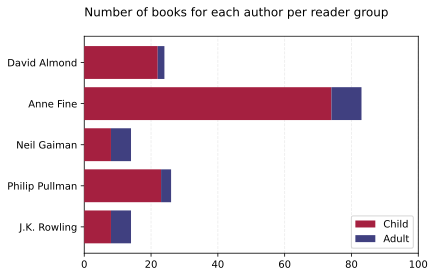

In [16]:
temp_df = df[['author', 'reader_age_group']]

ages_per_author = (
    list(
        reversed(temp_df
            .groupby('author', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )  # reverse order to match alphabetical order below
    )
)

x = list(set(temp_df['author'].values.tolist()))
x = sorted(x, key=lambda fullname: fullname.split(' ')[-1], reverse=True) # Reverse on reverse!

y1 = np.array(
    [ages_per_author[i] 
        for i in range(1, len(ages_per_author), len(temp_df.columns))]
)

y2 = np.array(
    [ages_per_author[i] 
        for i in range(0, len(ages_per_author), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.barh(x, y1, color=colors[0], zorder=5)
plt.barh(x, y2, left=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author per reader group", loc='left', pad=20)
plt.xlim(0, 100)
plt.grid(True, axis='x', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='lower right');

### Authors' gender per reader group

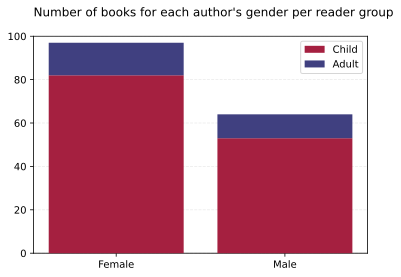

In [17]:
temp_df = df[['author_gender', 'reader_age_group']]

author_genders = (
    list(
        reversed(temp_df
            .groupby('author_gender', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )
    )
)

x = sorted(list(set(temp_df['author_gender'].values.tolist())))

y1 = np.array(
    [author_genders[i]
        for i in range(1, len(author_genders), len(temp_df.columns))]
)

y2 = np.array(
    [author_genders[i] 
        for i in range(0, len(author_genders), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.bar(x, y1, color=colors[0], zorder=5)
plt.bar(x, y2, bottom=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author's gender per reader group", loc='left', pad=20)
plt.ylim(0, 100)
plt.xticks([0, 1], labels=['Female', 'Male'])
plt.grid(True, axis='y', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='upper right');

### When did each author start writing for each reader group?

In [18]:
temp_df = df[['author', 'pub_year', 'reader_age_group']]

started = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .min()
)

ended = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .max()
)

period = pd.DataFrame({'earliest_pub': started, 'latest_pub': ended})
period

earliest_pub  latest_pub
author         reader_age_group                          
David Almond   child                     1998        2021
               adult                     2011        2014
Anne Fine      child                     1978        2019
               adult                     1986        2016
Neil Gaiman    child                     1999        2013
               adult                     1996        2015
Philip Pullman child                     1982        2020
               adult                     1972        2010
J.K. Rowling   child                     1997        2020
               adult                     2012        2020

In [19]:
earliest_year = period['earliest_pub'].min()
latest_year = period['latest_pub'].max()

earliest_year, latest_year

(1972, 2021)

In [20]:
time_df = df[['author', 'pub_year', 'reader_age_group']]

years = pd.date_range(
    start=f'01/01/{earliest_year}',
    end=f'01/01/{latest_year + 1}',
    freq='Y'
)

years_list = list(years.year.values)

time_df = (
    pd.concat([
        time_df,
        pd.DataFrame(
            np.NaN,
            columns=years_list,
            index=time_df.index
        )
    ],
    axis=1)
)

time_df['Counts'] = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .cumcount()
    .add(1)
)

works_df = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
)

works_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

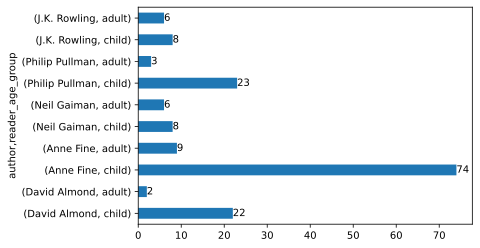

In [21]:
# Just to crosscheck with above df
ax = works_df.sum(axis=1).plot(kind='barh', legend=False)
ax.bar_label(ax.containers[0]);

In [22]:
test_df = works_df.transpose()

In [23]:
tidy_df = test_df.transpose()
tidy_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

In [24]:
tidy_df = (
    pd.melt(
        works_df.reset_index(),
        id_vars=('author', 'reader_age_group'),
        var_name='pub_year',
        value_name='count'
    )
)

print("Before:", tidy_df.shape)

tidy_df = (
    tidy_df[tidy_df['count'] > 0]
    .astype({'count': int})
)

print("After:", tidy_df.shape)

tidy_df['pub_year'] = pd.to_datetime(tidy_df['pub_year'], format='%Y').dt.year
tidy_df

Before: (430, 4)
After: (113, 4)


,author,reader_age_group,pub_year,count
7,Philip Pullman,adult,1972,1
12,Anne Fine,child,1978,1
17,Philip Pullman,adult,1978,1
22,Anne Fine,child,1979,1
32,Anne Fine,child,1980,1
...,...,...,...,...
410,David Almond,child,2020,2
416,Philip Pullman,child,2020,1
418,J.K. Rowling,child,2020,1
419,J.K. Rowling,adult,2020,1


In [25]:
simple_df = tidy_df.copy()

simple_df['pub_year_start'] = (
    pd.to_datetime(
        simple_df['pub_year'],
        format='%Y'
    )
    .dt.strftime('%Y-%m-%d')
)

simple_df['pub_year_end'] = (
    pd.to_datetime(simple_df['pub_year_start'], format='%Y-%m-%d')
    + pd.DateOffset(months=11, days=30)
)
simple_df.head()

,author,reader_age_group,pub_year,count,pub_year_start,pub_year_end
7,Philip Pullman,adult,1972,1,1972-01-01,1972-12-31
12,Anne Fine,child,1978,1,1978-01-01,1978-12-31
17,Philip Pullman,adult,1978,1,1978-01-01,1978-12-31
22,Anne Fine,child,1979,1,1979-01-01,1979-12-31
32,Anne Fine,child,1980,1,1980-01-01,1980-12-31


In [26]:
authors = [author for author in simple_df['author'].unique()]

author_1_df = simple_df[simple_df['author'] == authors[0]]
author_2_df = simple_df[simple_df['author'] == authors[1]]
author_3_df = simple_df[simple_df['author'] == authors[2]]
author_4_df = simple_df[simple_df['author'] == authors[3]]
author_5_df = simple_df[simple_df['author'] == authors[4]]

# Constants
CATEGORIES = {
    "child": 1,
    "adult": 2
}

CMAPS = {
    "child": "#a52040",
    "adult": "#404080"
}

START_YEAR = mdates.datestr2num(str(min(years_list) - 2)) # -2 to give some space on the left
END_YEAR = mdates.datestr2num(str(max(years_list) + 2))   # +2 to give some space on the right
TITLE_PAD = 16
Y_LABELS = ["Child", "Adult"]

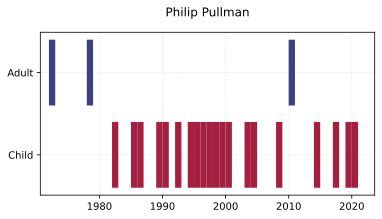

In [27]:
author_1 = author_1_df['author'].unique()[0]
data_1 = (author_1_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_1.keys()):
    if data_1[k] == 0:
        del data_1[k]

verts = []
colors = []

for d in data_1:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_1, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

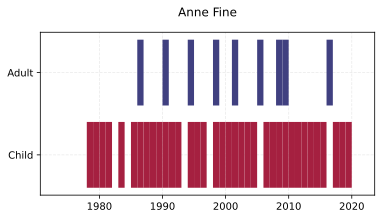

In [28]:
author_2 = author_2_df['author'].unique()[0]
data_2 = (author_2_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_2.keys()):
    if data_2[k] == 0:
        del data_2[k]

verts = []
colors = []

for d in data_2:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_2, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

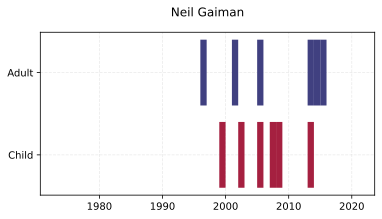

In [29]:
author_3 = author_3_df['author'].unique()[0]
data_3 = (author_3_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_3.keys()):
    if data_3[k] == 0:
        del data_3[k]

verts = []
colors = []

for d in data_3:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_3, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

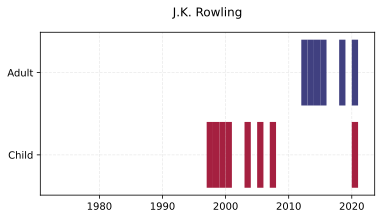

In [30]:
author_4 = author_4_df['author'].unique()[0]
data_4 = (author_4_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_4.keys()):
    if data_4[k] == 0:
        del data_4[k]

verts = []
colors = []

for d in data_4:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_4, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

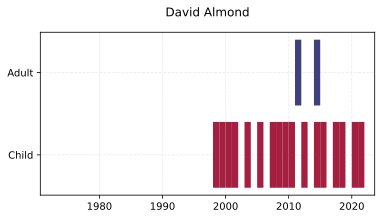

In [31]:
author_5 = author_5_df['author'].unique()[0]
data_5 = (author_5_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_5.keys()):
    if data_5[k] == 0:
        del data_5[k]

verts = []
colors = []

for d in data_5:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_5, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

## Preprocess corpus

In [32]:
df = pd.read_csv('data/metadata_en_final_sample.csv', encoding='utf-8')

print(df.shape)
df.sample(5)

(161, 7)


,file_name,author,title,pub_year,author_age_pub,author_gender,reader_age_group
69,FINE_savingmissmirabelle_2002,Anne Fine,Saving Miss Mirabelle,2002,55,F,child
47,FINE_holeintheroad_2014,Anne Fine,Hole in the Road,2014,67,F,child
143,PULLMAN_thetigerinthewell_1990,Philip Pullman,The Tiger in the Well,1990,44,M,child
14,ALMOND_secretheart_2001,David Almond,Secret Heart,2001,50,M,child
81,FINE_thegingerbreadstar_2015,Anne Fine,The Gingerbread Star,2015,68,F,child


In [33]:
included_authors = df['author'].unique()

included_authors_surnames = sorted(
    [included_authors[i].split(' ')[-1].upper()
        for i, _ in enumerate(included_authors)]
)

included_authors_surnames

['ALMOND', 'FINE', 'GAIMAN', 'PULLMAN', 'ROWLING']

### Finding the optimal `max_len`

Before loading the corpus, we need to see what the optimal value for `max_len` is, to include as many texts from each author as possible.

Since we are not going to be comparing the authors against each other &ndash;but, rather, how they write for the two different age groups of their readers&ndash; we are not affected by the amount of some authors being over or under-represented in the corpus.

In [34]:
def count_words_in_dir(
    directory: str = os.getcwd(), 
    *, 
    file_type: str = 'txt', 
    authors_list: list = None
) -> Dict[str, int]:

    word_counts = {}

    for file in glob.glob(os.path.join(directory, f'*.{file_type}')):
        filename, _ = os.path.splitext(os.path.basename(file))
        author = filename.split('_')[0]

        # Only include authors in the list, if provided
        if authors_list is not None:
            if author.upper() not in set(authors_list):
                continue

        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            contents = f.read()
        words = contents.split()
        filename = filename.removesuffix('.txt')
        
        word_counts[filename] = len(words)
    
    return word_counts

In [35]:
wc = count_words_in_dir('data/books_en/', authors_list=included_authors_surnames)

wc_df = pd.DataFrame.from_dict(wc, orient='index', columns=['word_count'])
wc_df.sample(5)

,word_count
ROWLING_careerofevil_2015,155140
FINE_eatingthingsonsticks_2009,28393
ROWLING_thesilkworm_2014,147456
FINE_apackofliars_1988,28302
FINE_flyintheointment_2008,59615


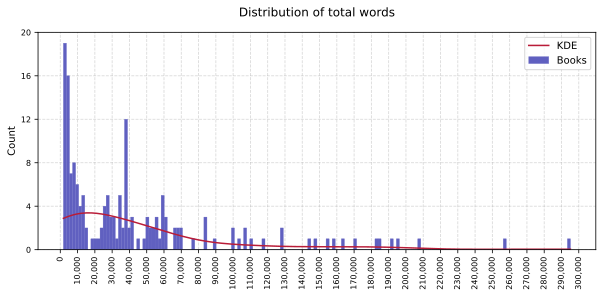

In [36]:
wc = wc_df['word_count']
bins = len(wc)
step = 10_000
x_ticks = np.arange(0, max(wc) + step, step)
palette = list(sns.color_palette('gist_stern', 8).as_hex())

fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(
    wc_df, x=wc,
    bins=bins, ax=ax, kde=True,
    palette=palette[:len(included_authors_surnames)], # remove the aweful yellow colors
    zorder=2
)

ax.lines[0].set_color(palette[0])

# A hacky way to change the color of the bins
for i in range(bins):
    ax.patches[i].set_facecolor('#6060c0')
    ax.patches[i].set_edgecolor('#6060c0')

# Format thousands separator in x-axis labels
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda tick, pos: format(int(tick), ','))
)

plt.title("Distribution of total words", pad=TITLE_PAD)
plt.ylabel("Count")
plt.yticks(np.arange(0, 21, 4), size=8)
plt.xlabel(None)
plt.xticks(x_ticks, size=8, rotation=90)
plt.legend(['KDE', 'Books'])
plt.grid(axis='both', linestyle='--', alpha=0.5, zorder=0);

### Taking entities into account

However, it is possible that the models will overfit to our dataset, by learning the names of characters, locations and organizations present in the books (e.g., "said \[name\]", "at Hogwarts", etc.). It is safe to say that, in case an author uses the same names for persons or locations in (a series of) books, it would be intentional rather than a coincidence. Therefore, two or more unrelated books not sharing entity names shows little to no interest for analysing an author's writing style.

By leveraging a pre-trained BERT model and with the power of HuggingFace, we can identify the persons and locations in the book and remove them from the final corpus:

In [37]:
bert_tokenizer = AutoTokenizer.from_pretrained('dslim/bert-large-NER')
bert_model = AutoModelForTokenClassification.from_pretrained('dslim/bert-large-NER')
nlp = pipeline('ner', model=bert_model, tokenizer=bert_tokenizer)

In [38]:
entity_tags = ['PER', 'LOC', 'ORG']

def _get_entities(text: str, tags: list = None) -> list:
    ner_list = nlp(text)

    current_name = []
    all_names_tmp = []

    for ner_dict in ner_list:
        # In BERT: B- = beginning token, I- = inside token
        if ner_dict['entity'] in [f'B-{tag}' for tag in entity_tags]:
            if len(current_name) == 0:
                current_name.append(ner_dict['word'])
            else:
                all_names_tmp.append([current_name])
                current_name = []
                current_name.append(ner_dict['word'])
        elif ner_dict['entity'] in [f'I-{tag}' for tag in entity_tags]:
            current_name.append(ner_dict['word'])

    all_names_tmp.append([current_name])

    # Flatten the list of lists
    all_names = []
    for name_list in all_names_tmp:
        full_name = ' '.join(name_list[0]).replace(' ##', '').replace(' .', '.')
        all_names.append([full_name])

    return [entity for elem in all_names for entity in elem]

def _remove_entities(text: str, *, tags: list = None, ents: list = None) -> str:

    if tags is None:
        raise NotImplementedError("A list of tags is required")

    if ents is None:
        ents = _get_entities(text=text, tags=tags)
    
    for entity in ents:
        text = text.replace(entity, '').strip()

    # Replace consecutive punctuation with 0 or more spaces 
    # Keep first matching group (e.g. '. ,' -> '.')
    text = re.sub(r"([.,/!#$%^&*;:{}=_`~()-])\s*[.,/!#$%^&*;:{}=_`~()-]+", r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    return text

## Loading the cleaned corpus

In [39]:
def load_directory(
    directory: str, 
    *, 
    file_type: str = 'txt', 
    max_length: int = 0,
    authors_list: list = None,
    remove_entities: bool = True
) -> list:
    filenames, texts, authors, titles = [], [], [], []
    for file in glob.glob(os.path.join(directory, f'*.{file_type}')):
        filename, _ = os.path.splitext(os.path.basename(file))
        author = filename.split('_')[0]

        # Only include authors in the list, if provided
        if authors_list is not None:
            if author.upper() not in set(authors_list):
                continue

        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            contents = f.read()

        lemmas = _remove_entities(contents, tags=['PER', 'LOC', 'ORG'])
        lemmas = lemmas.lower().split()
        start_idx, end_idx, segm = 0, max_length, 1

        while end_idx < len(lemmas):
            texts.append(" ".join(lemmas[start_idx:end_idx]))
            authors.append(author)
            title = filename.replace('.txt', '').split('_')[1]
            titles.append(f"{title}-{segm}")
            filenames.append(filename.removesuffix('.txt'))

            start_idx += max_length
            end_idx += max_length
            segm += 1

    return filenames, texts, authors, titles

In [40]:
filenames, texts, authors, titles = load_directory('data/books_en', max_length=1000, authors_list=included_authors_surnames)

print(len(filenames), len(texts), len(authors), len(titles))

7203 7203 7203 7203


In [41]:
print(set(authors))

{'GAIMAN', 'PULLMAN', 'FINE', 'ALMOND', 'ROWLING'}


In [42]:
# Check for missing files
# Option 1
print(len(set(filenames)) == len(set(wc_df.index)))

# Option 2
missing = len(set(wc_df.index.tolist()).difference(filenames))
print(f"{missing} missing files")

True
0 missing files


In [43]:
docs = (pd
    .DataFrame({
        'text': texts,
        'author': authors, 
        'file_name': filenames, 
        'segment': titles
    })
)
docs.sample(10)

,text,author,file_name,segment
331,"his brow. “hush,” she whispered. “what is it?”...",ALMOND,ALMOND_kitswilderness_1999,kitswilderness-20
1604,"i’ll take my time on this one, tilly.’) the fo...",FINE,FINE_rakingtheashes_2005,rakingtheashes-29
2299,"she was carrying, which i took to be hospital ...",FINE,FINE_uponcloudnine_2002,uponcloudnine-11
6180,slowly larger. snape was still drifting weirdl...,ROWLING,ROWLING_harrypotterandtheprisonerofazkaban_1999,harrypotterandtheprisonerofazkaban-94
6962,"with anna.” “good thinking,” said robin. “and ...",ROWLING,ROWLING_troubledblood_2020,troubledblood-53
4989,"uncontrolled yelp of dismay, his eyes on the p...",ROWLING,ROWLING_careerofevil_2015,careerofevil-30
1928,"temper over some small tease so that, instead ...",FINE,FINE_thedevilwalks_2011,thedevilwalks-49
0,i’m the one who’s left behind. i’m the one to ...,ALMOND,ALMOND_asongforellagrey_2014,asongforellagrey-1
3870,you shall have those as well. it is a great ta...,PULLMAN,PULLMAN_theamberspyglass_2000,theamberspyglass-22
4963,leg had been cut off. he was remembering the s...,ROWLING,ROWLING_careerofevil_2015,careerofevil-4


In [44]:
docs['file_name'].nunique()

166

In [45]:
df = (pd.merge(docs, meta, on='file_name'))

df = (df
    .drop('author_x', axis=1)
    .rename(columns={'author_y': 'author'})
)

df.sample(5)

,text,file_name,segment,author,title,pub_year,author_age_pub,author_gender,reader_age_group
6690,than most things. but you know that about me. ...,ROWLING_troubledblood_2020,troubledblood-160,J.K. Rowling,Troubled Blood,2020,55,F,adult
3222,"safe.’ ‘i was going to paint it,’ he told sist...",PULLMAN_labellesauvage_2017,labellesauvage-30,Philip Pullman,La Belle Sauvage,2017,71,M,child
6098,"and the sign was growing larger and larger, lu...",ROWLING_thecasualvacancy_2012,thecasualvacancy-79,J.K. Rowling,The Casual Vacancy,2012,47,F,adult
3125,"“who was it who planned the city, then?” “the ...",PULLMAN_galatea_1978,galatea-70,Philip Pullman,Galatea,1978,32,M,adult
1068,"‘do try not to be silly, dear. this is seriou—...",FINE_charmschool_1999,charmschool-6,Anne Fine,Charm School,1999,52,F,child


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6824 entries, 0 to 6823
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   text              6824 non-null   object  
 1   file_name         6824 non-null   object  
 2   segment           6824 non-null   object  
 3   author            6824 non-null   category
 4   title             6824 non-null   object  
 5   pub_year          6824 non-null   int64   
 6   author_age_pub    6824 non-null   int64   
 7   author_gender     6824 non-null   category
 8   reader_age_group  6824 non-null   category
dtypes: category(3), int64(2), object(4)
memory usage: 393.8+ KB


In [47]:
df.shape

(6824, 9)

In [48]:
df.groupby('author')['reader_age_group'].value_counts()

author                     
Aidan Chambers        adult       0
                      child       0
Anne Fine             child    1021
                      adult     514
David Almond          child     632
                      adult     139
Frank Cottrell-Boyce  adult       0
                      child       0
J.K. Rowling          child    1138
                      adult    1105
Jacqueline Wilson     adult       0
                      child       0
Jamila Gavin          adult       0
                      child       0
Jill Murphy           adult       0
                      child       0
Malorie Blackman      adult       0
                      child       0
Neil Gaiman           adult     457
                      child     230
Philip Pullman        child    1360
                      adult     228
Name: reader_age_group, dtype: int64

In [49]:
print(df['author'].cat.categories.tolist(), end='\n\n')
df['author'] = df['author'].cat.remove_unused_categories() # remove authors with 0 occurrences
print(df['author'].cat.categories.tolist())

['Aidan Chambers', 'Anne Fine', 'David Almond', 'Frank Cottrell-Boyce', 'J.K. Rowling', 'Jacqueline Wilson', 'Jamila Gavin', 'Jill Murphy', 'Malorie Blackman', 'Neil Gaiman', 'Philip Pullman']

['Anne Fine', 'David Almond', 'J.K. Rowling', 'Neil Gaiman', 'Philip Pullman']


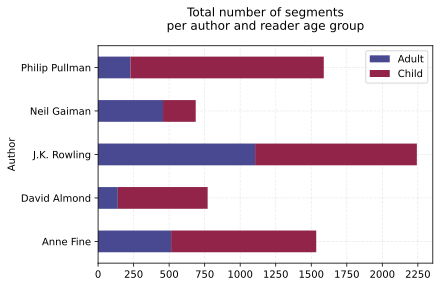

In [50]:
palette = list(sns.color_palette('gist_stern_r').as_hex())

(df
    .groupby(['author', 'reader_age_group'])
    .size()
    .unstack()
    .plot(kind='barh', stacked=True, color=palette[4:], zorder=2)
)

plt.title("Total number of segments\nper author and reader age group", pad=16)
plt.ylabel("Author")
plt.xticks(np.arange(0, 2500, 250))
plt.legend(['Adult', 'Child'])
plt.grid(axis='both', linestyle='--', alpha=.25, zorder=1);

In [51]:
df.to_csv('data/crosswriters_no_ents.csv', index=False, encoding='utf-8')